In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [391]:
data_g=pd.read_excel('./Data Science Test/Train.xlsx')
data_g.loc[:,'Time_data']=pd.to_datetime(data_g['YearMonth'],format='%Y%m')
if 'Time_data' in data_g.columns:
    data_g.set_index('Time_data',inplace=True)
data_req=data_g[['Volume']][6:30].copy()

0.000186636890653


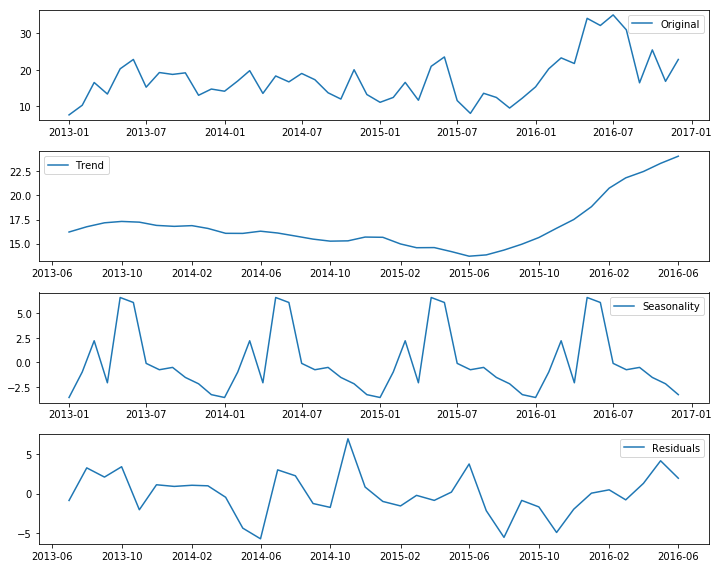

In [363]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_g[['Volume']])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(data_g['Volume'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

data_q=pd.DataFrame(data=residual)
data_q=data_q.dropna()
p_valu_adf=adfuller(data_q['Volume'].values,regression='c',autolag='AIC')[1]
print(p_valu_adf)

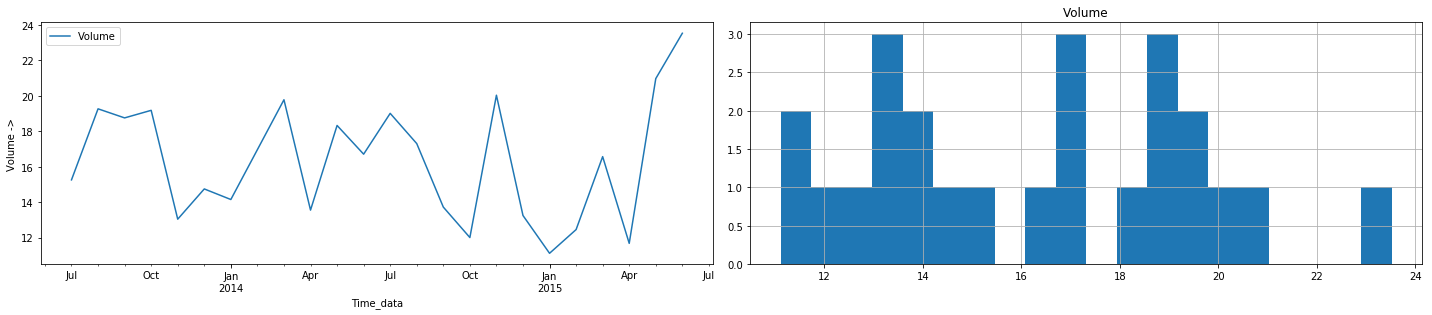

In [392]:
fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(221)
data_req[['Volume']].plot(ax=ax1)
ax1.set_ylabel("Volume ->")
ax2=fig.add_subplot(222)
data_req[['Volume']].hist(bins=20,ax=ax2)
fig.tight_layout()
x_up,x_low=np.percentile(data_req['Volume'],[95,5])

In [202]:
print(x_up,x_low)
data_req['Volume']=data_req['Volume'].apply(lambda x: x_up if x>x_up else x)
data_req['Volume']=data_req['Volume'].apply(lambda x: x_low if x<x_low else x)
data_req.describe().T

31.70292 9.81078


,count,mean,std,min,25%,50%,75%,max
Volume,48.0,17.541608,5.875919,9.81078,13.1904,16.6298,20.2776,31.70292


In [393]:
p_valu_adf=adfuller(data_req['Volume'][0:35].apply(lambda x:x).values,autolag='AIC')[1]
if p_valu_adf<0.05:
        print("This time series data has no unit root, so its non-stationary series. P Value is {}".format(p_valu_adf))
else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has no unit root, so its non-stationary series. P Value is 0.006604630529609209


In [429]:
data_req['Volume_diff']=data_req['Volume'].diff()
data_req['Volume_log']=data_req['Volume'].apply(lambda x:np.log(x))
data_req['Volume_sqrt']=data_req['Volume'].apply(lambda x:np.sqrt(x))
data_req['Volume_log_diff']=data_req['Volume_log'].diff()
data_req['Volume_sqrt_diff']=data_req['Volume_sqrt'].diff()
data_req['Volume_square']=data_req['Volume'].apply(lambda x:np.square(x))
data_req['Volume_square_diff']=data_req['Volume_square'].diff()

In [430]:
p_valu_adf=adfuller(data_req['Volume_log_diff'].dropna().values,autolag='AIC')[1]
if p_valu_adf<0.05:
        print("This time series data has no unit root, so its non-stationary series. P Value is {}".format(p_valu_adf))
else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has no unit root, so its non-stationary series. P Value is 1.1024465426772777e-09


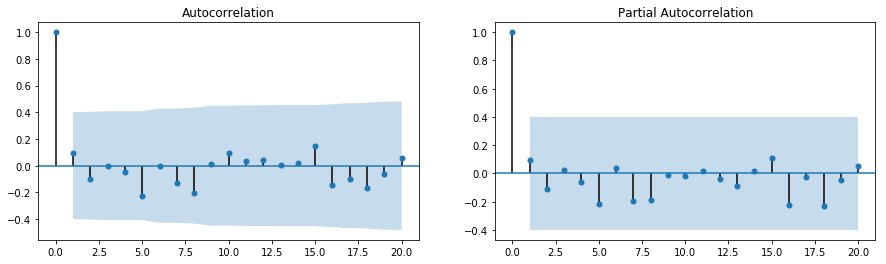

In [432]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data_req['Volume_log'], lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data_req['Volume_log'], lags=20, ax=axes[1])

In [436]:
model=SARIMAX(data_req['Volume_log'].dropna(),trend='ct',order=(2,1,1))
res=model.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             Volume_log   No. Observations:                   24
Model:               SARIMAX(2, 1, 1)   Log Likelihood                   2.153
Date:                Thu, 24 May 2018   AIC                              7.694
Time:                        23:11:22   BIC                             14.762
Sample:                    07-01-2013   HQIC                             9.569
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0258      0.050     -0.512      0.608      -0.125       0.073
drift          0.0022      0.004      0.533      0.594      -0.006       0.010
ar.L1          0.1511      0.336      0.450      0.6

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(-0.01744752000296157, 175.96556729320557)

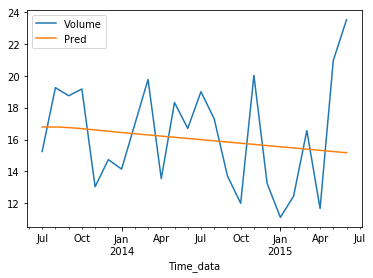

In [427]:
data_req['Pred']=res.predict(start='2013-07-01',end='2015-06-01',dynamic=True)
data_req[['Volume','Pred']].plot()
r2_score(data_req['Volume'],data_req['Pred']),mean_squared_error(data_req['Volume_log'],data_req['Pred'])

In [425]:
data_req.head();data_pred.head()

,Volume,Volume_diff,Volume_log,Volume_sqrt,Volume_log_diff,Volume_sqrt_diff,Volume_square,Volume_square_diff,Pred
Time_data,,,,,,,,,
2016-01-01,15.3360,3.0672,2.730203,3.916121,0.223144,0.413436,235.192896,84.669443,2.681609
2016-02-01,20.2776,4.9416,3.009517,4.503066,0.279314,0.586945,411.181062,175.988166,2.550838
2016-03-01,23.2596,2.9820,3.146718,4.822821,0.137201,0.319755,541.008992,129.827930,2.345720
2016-04-01,21.7260,-1.5336,3.078510,4.661116,-0.068208,-0.161705,472.019076,-68.989916,2.593432
2016-05-01,34.0800,12.3540,3.528711,5.837808,0.450201,1.176692,1161.446400,689.427324,2.669242


In [433]:
data_req

,Volume,Volume_diff,Volume_log,Volume_sqrt,Volume_log_diff,Volume_sqrt_diff,Volume_square,Volume_square_diff,Pred
Time_data,,,,,,,,,
2013-07-01,15.2508,NaN,2.724632,3.905227,NaN,NaN,232.586901,NaN,16.785503
2013-08-01,19.2552,4.0044,2.957781,4.388075,0.233149,0.482847,370.762727,138.175826,16.785503
2013-09-01,18.7440,-0.5112,2.930874,4.329434,-0.026907,-0.058641,351.337536,-19.425191,16.749160
2013-10-01,19.1700,0.4260,2.953347,4.378356,0.022473,0.048922,367.488900,16.151364,16.681758
2013-11-01,13.0356,-6.1344,2.567684,3.610485,-0.385662,-0.767871,169.926867,-197.562033,16.600237
2013-12-01,14.7396,1.7040,2.690538,3.839219,0.122854,0.228734,217.255808,47.328941,16.517271
2014-01-01,14.1432,-0.5964,2.649234,3.760745,-0.041304,-0.078474,200.030106,-17.225702,16.437897
2014-02-01,16.9548,2.8116,2.830551,4.117621,0.181317,0.356876,287.465243,87.435137,16.362088
2014-03-01,19.7664,2.8116,2.983984,4.445942,0.153433,0.328321,390.710569,103.245326,16.288097


In [214]:
!pip install keras

In [218]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
#dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = data_req[['Volume']].values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [220]:
r2_score(testY[0], testPredict[:,0])

-0.8154796106725215